# PPE analysis template
- Daniel Kennedy (djk2120@ucar.edu)
- updated Oct 22, 2021
- note that there are dependencies to other files in the repo

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import statsmodels.api as sm
import os

## set up your PBSCluster
- note: this may cause a pink warning message
- but it's safe to ignore
- make sure to wait until client.cluster shows that your workers are active

In [3]:
# Setup your PBSCluster

project = 'P93300641' #input your project code

cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='25GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB', # Specify resources
    project=project, # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(20)

# Setup your client
client = Client(cluster)

In [4]:
## wait until workers >0
client.cluster

In [6]:
### import some analysis functions we wrote for this project
###  note that you can inspect the code for these functions in ../ppe_tools/analysis.py
import sys ; sys.path.append("..")
from ppe_tools.analysis import get_ensemble, month_wts, get_cfs, top_n, calc_mean, rank_plot

### LOAD THE ENSEMBLE
- monthly data is htape='h0'
- daily is htape ='h5'

In [7]:
#define the directory structure and find files
def get_files(name,htape,keys):
    topdir     = '/glade/scratch/djk2120/PPEn11/hist/' 
    thisdir    = topdir+name+'/'
    files      = [glob.glob(thisdir+'*'+key+'*'+htape+'*.nc')[0] for key in keys]
    return files

In [8]:
#fetch the paraminfo
csv = '/glade/scratch/djk2120/PPEn11/surv.csv' 
paramkey = pd.read_csv(csv)

#fetch the sparsegrid landarea
la_file = '/glade/scratch/djk2120/PPEn08/sparsegrid_landarea.nc'
la = xr.open_dataset(la_file).landarea  #km2

#load conversion factors
cfs,units = get_cfs()

In [9]:
#read the ensemble
keys  = paramkey.key
htape = 'h0'
name  = 'CTL2010'
files = get_files(name,htape,keys)
data_vars = ['GPP']
ds = get_ensemble(files,data_vars,keys,paramkey)

### examine GPP, one ensemble member

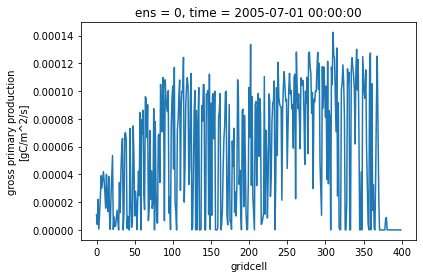

In [24]:
## note that the output is not global, but rather a subset of 400 meaningful pixels
##   so you can't plot a map directly
ds.GPP.isel(ens=0,time=6).plot();    #ens0 = default

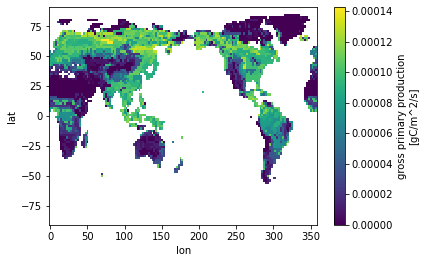

In [25]:
## but we have a function to map the sparsegrid to a global map: get_map
##   it is a little bit slow.....
da_map = get_map(ds.GPP.isel(ens=0,time=6))
da_map.plot();

In [26]:
help(get_map)

Help on function get_map in module __main__:

get_map(da)
    Regrid from sparsegrid to standard lat/lon
    
    Better to do any dimension-reducing math before calling this function. 
    Could otherwise be pretty slow...



### examine average GPP, all ensemble members

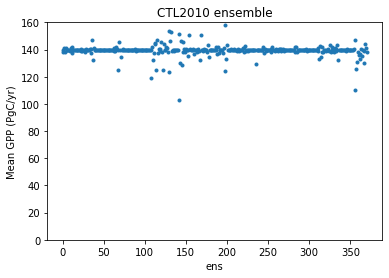

In [35]:
cf1 = 1e-9
cf2 = 24*60*60
nyrs = 10

gpp_glob     = cf1*(la*ds.GPP).sum(dim='gridcell')                          #PgC/s
gpp_glob_ann = cf2*(month_wts(nyrs)*gpp_glob).groupby('time.year').sum()    #PgC/yr
gpp_glob_avg = gpp_glob_ann.mean(dim='year').compute()

gpp_glob_avg.plot.line('.')
plt.ylabel('Mean GPP (PgC/yr)')
plt.title('CTL2010 ensemble')
plt.ylim([0,160]);

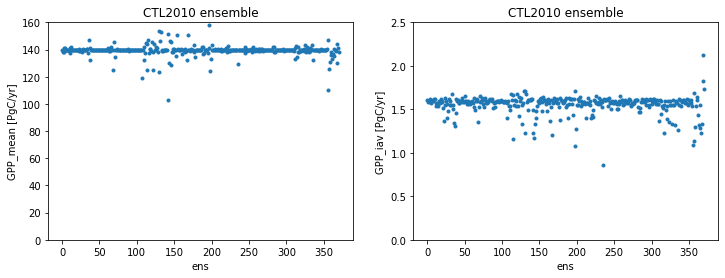

In [44]:
#we wrote a shortcut function to perform avg/iav calculations
# this also stores the result in ./data, so you don't have to redo the calcs every time you open the notebook
ens_name = 'CTL2010'
datavar  = 'GPP'
xm,iav = calc_mean(ds, ens_name, datavar, la, cfs, units)

plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
xm.plot.line('.')
plt.ylim([0,160])
plt.title('CTL2010 ensemble');
plt.subplot(1,2,2)
iav.plot.line('.')
plt.ylim([0,2.5])
plt.title('CTL2010 ensemble');


In [46]:
## the perturbations are described via ds.param, ds.minmax
for i in range(10):
    print(ds.param.sel(ens=i).values,ds.minmax.sel(ens=i).values )

default default
taulnir min
taulnir max
taulvis min
taulvis max
tausnir min
tausnir max
tausvis min
tausvis max
rholnir min


In [106]:
#examine perturbation effects via: top_n
nx = 10
xmins,xmaxs,pvals = top_n(xm, nx, ds.param, ds.minmax)
pvals

['tpu25ratio',
 'fff',
 'wc2wjb0',
 'theta_cj',
 'jmaxb1',
 'medlynslope',
 'jmaxb0',
 'medlynintercept',
 'leafcn',
 'kmax']

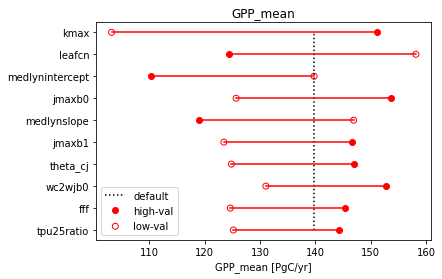

In [108]:
#handy plotter
rank_plot(xm, ds, nx)

### look at a single gridcell

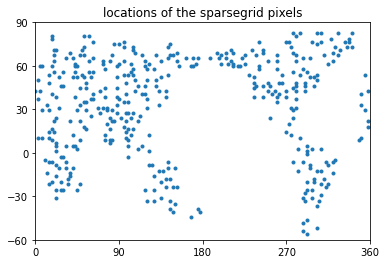

In [115]:
plt.plot(ds.grid1d_lon,ds.grid1d_lat,'.')
plt.xlim([0,360]); plt.xticks(90*np.arange(5))
plt.ylim([-60,90]); plt.yticks(-60+30*np.arange(6))
plt.title('locations of the sparsegrid pixels');

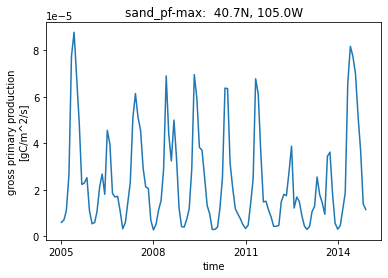

In [141]:
lat = 40
lon = 360-105  #105W

#find nearest point
d = np.sqrt((ds.grid1d_lat-lat)**2+(ds.grid1d_lon-lon)**2)
ix = d==np.min(d)

#convert to N/s E/W
thislat = np.round(ds.grid1d_lat[ix].values[0],1)
thislon = ds.grid1d_lon[ix].values[0]
if thislon<180:
    lond = 'E'
else:
    thislon=360-thislon
    lond = 'W'
latd='N'
if thislat<0:
    latd='S'
   
#pick an ensemble member and plot
ee = 368
p = str(ds.param.isel(ens=ee).values)
m = str(ds.minmax.isel(ens=ee).values)

ds.GPP.isel(ens=ee,gridcell=ix).plot()
plt.title(p+'-'+m+':  '+str(thislat)+latd+', '+str(thislon)+lond);
    

### Examine param perturbation values

In [102]:
## if you want to examine the actual values of a given param
param = 'jmaxb1'

## shouldn't need to edit below

ix = ds.param==param
params = ['default',*ds.param.isel(ens=ix).values]
minmax = ['default',*ds.minmax.isel(ens=ix).values]

ix = ds.ens>np.inf
for p,m in zip(params,minmax):
    ix = (ix)|((ds.param==p)&(ds.minmax==m))

keys = ds.key.isel(ens=ix).values
pvals = []
pdir = '/glade/scratch/djk2120/PPEn11/paramfiles/'
ndir = '/glade/scratch/djk2120/PPEn11/namelist_mods/'
lndin = '/glade/work/oleson/lmbirch_wkattge.n01_ctsm5.1.dev006/cime/scripts/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_PPE_1850pAD/CaseDocs/lnd_in'
for key,p in zip(keys,params):
    pf = xr.open_dataset(pdir+key+'.nc')
    if param in pf.data_vars:
        pvals.append(pf[param].values)
    else:
        nfile = ndir+key+'.txt'
        if p=='default':
            cmd = 'grep '+param+' '+lndin
            tmp = os.popen(cmd).read().split()[2]
            if 'd' in tmp:
                tmp = tmp.split('d')
                pval = float(tmp[0])*10**float(tmp[1])
            else:
                pval = float(tmp)
        else:
            with open(nfile) as f:
                lines = f.readlines()
                pval = float(lines[1].split('=')[1].split('\n')[0])
        pvals.append(pval)

In [103]:
### note that default may also serve as min or max
for i,m in enumerate(minmax):
    print(param,m,pvals[i])

jmaxb1 default 0.17
jmaxb1 min 0.05
jmaxb1 max 0.25


### examine a sample file
- useful for checking which variables are available

In [ ]:
h0 = '/glade/scratch/djk2120/PPEn11/hist/CTL2010/PPEn11_CTL2010_OAAT0400.clm2.h0.2005-02-01-00000.nc'
ds0 = xr.open_dataset(h0)
ds0.data_vars

Data variables: (12/497)
    mcdate                             (time) int32 ...
    mcsec                              (time) int32 ...
    mdcur                              (time) int32 ...
    mscur                              (time) int32 ...
    nstep                              (time) int32 ...
    time_bounds                        (time, hist_interval) object ...
    ...                                 ...
    XSMRPOOL                           (time, gridcell) float32 ...
    XSMRPOOL_RECOVER                   (time, gridcell) float32 ...
    ZBOT                               (time, gridcell) float32 ...
    ZWT                                (time, gridcell) float32 ...
    ZWT_CH4_UNSAT                      (time, gridcell) float32 ...
    ZWT_PERCH                          (time, gridcell) float32 ...

In [ ]:
h5 = '/glade/scratch/djk2120/PPEn11/hist/CTL2010/PPEn11_CTL2010_OAAT0400.clm2.h5.2005-01-01-00000.nc'
ds5 = xr.open_dataset(h5)
ds5.data_vars

Data variables: (12/89)
    mcdate              (time) int32 ...
    mcsec               (time) int32 ...
    mdcur               (time) int32 ...
    mscur               (time) int32 ...
    nstep               (time) int32 ...
    time_bounds         (time, hist_interval) object ...
    ...                  ...
    TSOI_10CM           (time, gridcell) float32 ...
    TV                  (time, gridcell) float32 ...
    TWS                 (time, gridcell) float32 ...
    VEGWPLN             (time, nvegwcs, gridcell) float32 ...
    VEGWPPD             (time, nvegwcs, gridcell) float32 ...
    VPD_CAN             (time, gridcell) float32 ...